# Project


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway, kruskal
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from scipy.stats import norm
from google.colab import files
uploaded = files.upload()

df= pd.read_csv("Houses.csv")
df.head()

Saving Houses.csv to Houses (3).csv


,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
0,Duplex,4000000,3.0,3.0,400.0,No,7,Unknown,Cash,Ready to move,Finished,Nasr City
1,Apartment,4000000,3.0,3.0,160.0,No,10+,Unknown,Cash,Ready to move,Finished,Camp Caesar
2,Apartment,2250000,3.0,2.0,165.0,No,1,Unknown,Cash,Ready to move,Finished,Smoha
3,Apartment,1900000,3.0,2.0,230.0,No,10,Unknown,Cash,Ready to move,Finished,Nasr City
4,Apartment,5800000,2.0,3.0,160.0,No,Ground,Eastown,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27361 entries, 0 to 27360
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Type            27361 non-null  object
 1   Price           27359 non-null  object
 2   Bedrooms        27158 non-null  object
 3   Bathrooms       27190 non-null  object
 4   Area            26890 non-null  object
 5   Furnished       27361 non-null  object
 6   Level           27361 non-null  object
 7   Compound        27361 non-null  object
 8   Payment_Option  27361 non-null  object
 9   Delivery_Date   27361 non-null  object
 10  Delivery_Term   27361 non-null  object
 11  City            27361 non-null  object
dtypes: object(12)
memory usage: 2.5+ MB


# Cleaning The Dataset

In [56]:
df.loc[df['Type'] == "Unknown", 'Type'] = np.nan
df.dropna(subset=['Type'], inplace = True)


In [57]:
df = df.copy()

numeric_columns = ["Price", "Bedrooms", "Bathrooms", "Area"]
for col in numeric_columns:
    df.loc[df[col] == "Unknown", col] = np.nan

df = df.dropna(subset=numeric_columns)
df.loc[:, ["Price", "Area"]] = df[["Price", "Area"]].astype('float64')

In [58]:
df.loc[df['Bathrooms'] == '10+', 'Bathrooms'] = 11
df.loc[df['Bedrooms'] == '10+', 'Bedrooms'] = 11

In [59]:
df['Bathrooms'] = pd.to_numeric(df['Bathrooms'], errors='coerce')
df['Bathrooms'] = df['Bathrooms'].fillna(0).astype(int)

In [60]:
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['Bedrooms'] = df['Bedrooms'].fillna(0).astype(int)

In [61]:
df['Level'] = df['Level'].apply(lambda x: x if x != 'Unknown' else np.nan)
df['Level'] = df['Level'].apply(lambda x: 0 if x == 'Ground' else (12 if x == '10+' else (15 if x == 'Highest' else x)))

In [62]:
df['Level'] = df['Level'].astype('float')
df['Level'] = df['Level'].fillna(df['Level'].mean())
df["Level"] = df["Level"].astype("int")

In [63]:
df.loc[df['Compound'] == 'Unknown', 'Compound'] = 'not in compound'


In [64]:
df.head()


,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
0,Duplex,4000000.0,3,3,400.0,No,7,not in compound,Cash,Ready to move,Finished,Nasr City
1,Apartment,4000000.0,3,3,160.0,No,12,not in compound,Cash,Ready to move,Finished,Camp Caesar
2,Apartment,2250000.0,3,2,165.0,No,1,not in compound,Cash,Ready to move,Finished,Smoha
3,Apartment,1900000.0,3,2,230.0,No,10,not in compound,Cash,Ready to move,Finished,Nasr City
4,Apartment,5800000.0,2,3,160.0,No,0,Eastown,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa


In [53]:
df.describe()

,Price,Bedrooms,Bathrooms,Area,Level
count,2.669300e+04,26693.000000,26693.000000,26693.000000,26693.000000
mean,4.387421e+06,3.201251,2.760012,226.736283,2.060203
std,5.564672e+06,1.155990,1.281616,157.539997,2.072674
min,3.000000e+04,1.000000,1.000000,10.000000,0.000000
25%,1.100000e+06,3.000000,2.000000,125.000000,1.000000
50%,2.685000e+06,3.000000,3.000000,175.000000,2.000000
75%,5.550000e+06,4.000000,3.000000,270.000000,2.000000
max,2.050000e+08,11.000000,11.000000,995.000000,15.000000


# Visualizations


In [77]:
type_counts = df['Type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

sns.barplot(x='Type', y='Count', data=type_counts)
plt.xticks(rotation=90)
plt.show()

sns.histplot(df['Level'], binwidth=1)
plt.show()

sns.kdeplot(df['Level'])
plt.show()

df['Parsed_SubCity'] = df['City']
top_subcities = df['Parsed_SubCity'].value_counts().nlargest(5).index.tolist()
df_top = df[df['Parsed_SubCity'].isin(top_subcities)]

sns.set(style="whitegrid")


plt.figure(figsize=(8, 6))
sns.heatmap(df[['Price', 'Bedrooms', 'Bathrooms', 'Area']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Features and Price")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
avg_prices = df_top.groupby("Parsed_SubCity")["Price"].mean().sort_values(ascending=False)
sns.barplot(x=avg_prices.values, y=avg_prices.index, palette="viridis")
plt.title("Average Property Price in Top 5 Sub-Cities")
plt.xlabel("Average Price (EGP)")
plt.ylabel("Sub-City")
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.yscale('log')
sns.boxplot(x='Bedrooms', y='Price', data=df, ax=axs[0])
axs[0].set_title('Price by Bedrooms')
sns.boxplot(x='Bathrooms', y='Price', data=df, ax=axs[1])
plt.yscale('log')
axs[1].set_title('Price by Bathrooms')
for ax in axs:
    ax.set_ylabel("Price (EGP)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x="Area", y="Price", data=df, hue="Parsed_SubCity", alpha=0.7)
plt.title("Price vs Area (colored by Sub-City)")
plt.xlabel("Area (sqm)")
plt.ylabel("Price (EGP)")
plt.legend(title="Sub-City")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.violinplot(data=df_top, x="Parsed_SubCity", y="Price", palette="Set2", scale="width")
plt.title("Distribution of Prices in Top Sub-Cities")
plt.ylabel("Price (EGP)")
plt.xlabel("Sub-City")
plt.tight_layout()
plt.show()

sns.pairplot(df_top, vars=["Price", "Area", "Bedrooms", "Bathrooms"], hue="Parsed_SubCity", corner=True)
plt.suptitle("Pairwise Feature Relationships by Sub-City", y=1.02)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Area", y=np.log1p(df['Price']), hue="Parsed_SubCity", alpha=0.7)
plt.title("Log-Price vs Area (Reveals Skewed Price Distribution)")
plt.xlabel("Area (sqm)")
plt.ylabel("Log(Price + 1)")
plt.tight_layout()
plt.show()

for feature in ['Area', 'Bedrooms', 'Bathrooms']:
    sns.lmplot(data=df, x=feature, y='Price', line_kws={'color': 'red'})
    plt.title(f"{feature.title()} vs Price — Full Dataset")
    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Analyze Price Variation Across Developers Within Top Sub-Cities (Fixed Beds, Baths, and Area)

In [95]:
fixed_beds = 3
fixed_baths = 2
min_area = 140
max_area = 240

top_subcities = ['North Coast', 'Madinaty', 'New Cairo - El Tagamoa', 'Sheikh Zayed']

for subcity in top_subcities:
    print(f"\n--- Analyzing {subcity} ---")

    sub_df = df[
        (df['Parsed_SubCity'] == subcity) &
        (df['Bedrooms'] == fixed_beds) &
        (df['Bathrooms'] == fixed_baths) &
        (df['Area'] >= min_area) &
        (df['Area'] <= max_area)
    ].copy()

    if len(sub_df) >= 1000:
        sub_df = sub_df.sample(n=1000, random_state=42)

    print(f"Found {len(sub_df)} listings matching criteria in {subcity}.")

    groups = [group['Price'].values for _, group in sub_df.groupby('Compound') if len(group) >= 1]
    developer_names = [name for name, group in sub_df.groupby('Compound') if len(group) >= 1]

    print(f"Analyzing {len(sub_df)} listings across {sub_df['Compound'].nunique()} unique developers in {subcity}.")
    print(f"Using {len(groups)} developer groups with 3+ listings for statistical tests.")

    if len(groups) >= 2:
        try:
            f_stat, anova_p = f_oneway(*groups)
            print(f"ANOVA test (F-statistic={f_stat:.4f}, p-value={anova_p:.4f})")
            if anova_p < 0.05:
                print("Conclusion: Significant difference in mean price between developers (ANOVA).")
            else:
                print("Conclusion: No significant difference in mean price between developers (ANOVA).")
        except ValueError as e:
            print(f"Could not perform ANOVA: {e}")

        try:
            kw_stat, kw_p = kruskal(*groups)
            print(f"Kruskal-Wallis test (Statistic={kw_stat:.4f}, p-value={kw_p:.4f})")
            if kw_p < 0.05:
                print("Conclusion: Significant difference in median price between developers (Kruskal-Wallis).")
            else:
                print("Conclusion: No significant difference in median price between developers (Kruskal-Wallis).")
        except ValueError as e:
            print(f"Could not perform Kruskal-Wallis: {e}")
    else:
        print("Statistical tests skipped — not enough developer groups with 3+ listings.")

    if not sub_df.empty:
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=sub_df, x='Compound', y='Price', palette='viridis')
        plt.yscale('log')
        plt.title(f'{subcity} — Price Distribution per Developer\n(Beds={fixed_beds}, Baths={fixed_baths}, Area={min_area}-{max_area} sqm)')
        plt.xlabel('Developer')
        plt.ylabel('Price (EGP)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 7))
        sns.stripplot(data=sub_df, x='Compound', y='Price', jitter=True, alpha=0.6, color='blue', label='Individual Listings')
        mean_prices_per_developer = sub_df.groupby('Compound')['Price'].mean().reset_index()
        sns.pointplot(data=mean_prices_per_developer, x='Compound', y='Price', color='red', markers='o', linestyles='-', errorbar=None, label='Mean Price')
        plt.title(f'{subcity} — Developer Price Spread w/ Mean Overlay\n(Beds={fixed_beds}, Baths={fixed_baths}, Area={min_area}-{max_area} sqm)')
        plt.xlabel('Developer')
        plt.ylabel('Price (EGP)')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 7))
        avg_prices = sub_df.groupby('Compound')['Price'].mean().sort_values(ascending=False)
        avg_prices.plot(kind='bar', color=sns.color_palette('pastel')[0])
        plt.title(f'{subcity} — Avg Price per Developer (Fixed Features)\n(Beds={fixed_beds}, Baths={fixed_baths}, Area={min_area}-{max_area} sqm)')
        plt.xlabel('Compound')
        plt.ylabel('Average Price (EGP)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot for this sub-city and criteria.")


df_not_in_compound = df[df['Compound'] == 'not in compound']
city_counts = df_not_in_compound['City'].value_counts().nlargest(10)
top_cities_df = df_not_in_compound[df_not_in_compound['City'].isin(city_counts.index)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_cities_df, x='City', y='Price')
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Price Distribution of "Not in Compound" Houses in Top 10 Cities')
plt.ylabel('Price')
plt.xlabel('City')
plt.tight_layout()
plt.show()


mean_prices = top_cities_df.groupby('City')['Price'].mean().reset_index()
mean_prices = mean_prices.sort_values(by='Price', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
sns.regplot(data=mean_prices, x=mean_prices.index, y='Price', scatter_kws={"s": 100}, line_kws={"color": "red"})

plt.xticks(ticks=mean_prices.index, labels=mean_prices['City'], rotation=45)
plt.title('Regression of Mean Prices for Top 10 Cities (Not in Compound)')
plt.xlabel('City')
plt.ylabel('Mean Price')
plt.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Compute Pearson Correlation Between Property Features and Price per Sub-City

In [84]:
def calculate_pearson_correlations(df, features, target):
    correlations = {}
    for feature in features:
        corr = df[[feature, target]].corr().iloc[0, 1]
        correlations[feature] = corr
    return correlations

features = ['Bedrooms', 'Bathrooms', 'Area']
target = 'Price'

for sub_city in top_subcities:
    df_sub_city = df[df['Parsed_SubCity'] == sub_city]
    correlations = calculate_pearson_correlations(df_sub_city, features, target)

    print(f"Pearson Correlations for {sub_city}:")
    for feature, corr in correlations.items():
        print(f"  {feature}: {corr:.4f}")
    print("-" * 50)


Pearson Correlations for North Coast:
  Bedrooms: 0.4541
  Bathrooms: 0.5466
  Area: 0.5973
--------------------------------------------------
Pearson Correlations for Madinaty:
  Bedrooms: 0.6397
  Bathrooms: 0.7228
  Area: 0.8248
--------------------------------------------------
Pearson Correlations for New Cairo - El Tagamoa:
  Bedrooms: 0.5259
  Bathrooms: 0.6150
  Area: 0.7317
--------------------------------------------------
Pearson Correlations for Sheikh Zayed:
  Bedrooms: 0.4424
  Bathrooms: 0.5122
  Area: 0.5871
--------------------------------------------------


# Confidence Intervals for Mean Prices per City and Pairwise Price Comparison (t-test)

Pairwise t-test results:
Comparison: North Coast vs Madinaty
t-statistic: -11.7118, p-value: 0.0000
--------------------------------------------------
Comparison: North Coast vs New Cairo - El Tagamoa
t-statistic: -21.6760, p-value: 0.0000
--------------------------------------------------
Comparison: North Coast vs Sheikh Zayed
t-statistic: -17.2319, p-value: 0.0000
--------------------------------------------------
Comparison: Madinaty vs New Cairo - El Tagamoa
t-statistic: -2.0019, p-value: 0.0454
--------------------------------------------------
Comparison: Madinaty vs Sheikh Zayed
t-statistic: -0.8263, p-value: 0.4087
--------------------------------------------------
Comparison: New Cairo - El Tagamoa vs Sheikh Zayed
t-statistic: 1.4909, p-value: 0.1360
--------------------------------------------------


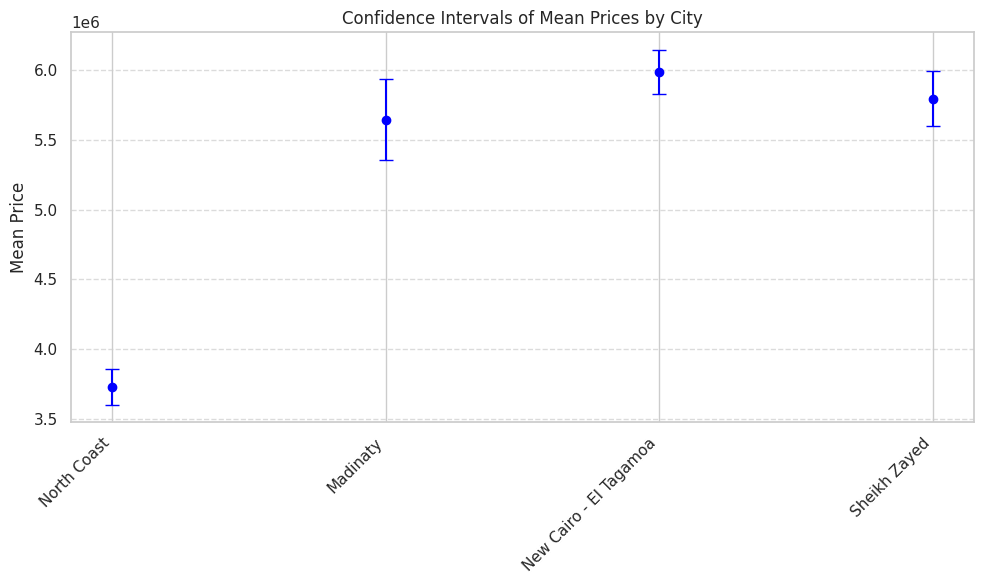

In [85]:
confidence_level = 0.95
city_stats = {}

for sub_city in top_subcities:
    df_sub_city = df[df['Parsed_SubCity'] == sub_city]
    prices = df_sub_city['Price']

    n = len(prices)
    mean_price = np.mean(prices)
    std_price = np.std(prices, ddof=1)

    t_critical = stats.t.ppf((1 + confidence_level) / 2, df=n-1)
    margin_of_error = t_critical * (std_price / np.sqrt(n))

    city_stats[sub_city] = {
        "mean": mean_price,
        "ci_lower": mean_price - margin_of_error,
        "ci_upper": mean_price + margin_of_error,
        "n": n,
        "std": std_price
    }

t_test_results = {}
for i, city1 in enumerate(top_subcities):
    for city2 in top_subcities[i+1:]:
        prices1 = df[df['Parsed_SubCity'] == city1]['Price']
        prices2 = df[df['Parsed_SubCity'] == city2]['Price']

        t_stat, p_value = stats.ttest_ind(prices1, prices2, equal_var=False)
        t_test_results[(city1, city2)] = {
            "t_stat": t_stat,
            "p_value": p_value
        }

print("Pairwise t-test results:")
for pair, result in t_test_results.items():
    print(f"Comparison: {pair[0]} vs {pair[1]}")
    print(f"t-statistic: {result['t_stat']:.4f}, p-value: {result['p_value']:.4f}")
    print("-" * 50)

fig, ax = plt.subplots(figsize=(10, 6))
cities = list(city_stats.keys())
means = [city_stats[city]["mean"] for city in cities]
ci_lowers = [city_stats[city]["ci_lower"] for city in cities]
ci_uppers = [city_stats[city]["ci_upper"] for city in cities]

ax.errorbar(
    cities,
    means,
    yerr=[means[i] - ci_lowers[i] for i in range(len(cities))],
    fmt='o',
    capsize=5,
    label="Mean Price with CI",
    color='blue'
)

ax.set_ylabel("Mean Price")
ax.set_title("Confidence Intervals of Mean Prices by City")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Pairwise Z-Tests for Comparing Mean Prices Between Sub-Cities

In [86]:
z_test_results = {}

for i, city1 in enumerate(top_subcities):
    for city2 in top_subcities[i+1:]:
        prices1 = df[df['Parsed_SubCity'] == city1]['Price']
        prices2 = df[df['Parsed_SubCity'] == city2]['Price']

        mean1, mean2 = np.mean(prices1), np.mean(prices2)
        std1, std2 = np.std(prices1, ddof=1), np.std(prices2, ddof=1)
        n1, n2 = len(prices1), len(prices2)

        pooled_std_error = np.sqrt((std1**2 / n1) + (std2**2 / n2))
        z_stat = (mean1 - mean2) / pooled_std_error
        p_value = 2 * (1 - norm.cdf(abs(z_stat)))

        z_test_results[(city1, city2)] = {
            "z_stat": z_stat,
            "p_value": p_value
        }

print("Pairwise z-test results:")
for pair, result in z_test_results.items():
    print(f"Comparison: {pair[0]} vs {pair[1]}")
    print(f"z-statistic: {result['z_stat']:.4f}, p-value: {result['p_value']:.4f}")
    print("-" * 50)


Pairwise z-test results:
Comparison: North Coast vs Madinaty
z-statistic: -11.7118, p-value: 0.0000
--------------------------------------------------
Comparison: North Coast vs New Cairo - El Tagamoa
z-statistic: -21.6760, p-value: 0.0000
--------------------------------------------------
Comparison: North Coast vs Sheikh Zayed
z-statistic: -17.2319, p-value: 0.0000
--------------------------------------------------
Comparison: Madinaty vs New Cairo - El Tagamoa
z-statistic: -2.0019, p-value: 0.0453
--------------------------------------------------
Comparison: Madinaty vs Sheikh Zayed
z-statistic: -0.8263, p-value: 0.4086
--------------------------------------------------
Comparison: New Cairo - El Tagamoa vs Sheikh Zayed
z-statistic: 1.4909, p-value: 0.1360
--------------------------------------------------


# Pairwise Cohen's d Effect Sizes Between Top Sub-Cities

In [87]:
def interpret_effect_size(d):
    if abs(d) < 0.2:
        return "negligible"
    elif abs(d) < 0.5:
        return "small"
    elif abs(d) < 0.8:
        return "medium"
    else:
        return "large"
def cohens_d(mean1, mean2, std1, std2, n1, n2):
    pooled_std = (((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))**0.5
    d = (mean1 - mean2) / pooled_std
    return d
effect_size_results = []

for i, city1 in enumerate(top_subcities):
    for city2 in top_subcities[i+1:]:
        mean1 = city_stats[city1]["mean"]
        mean2 = city_stats[city2]["mean"]
        std1 = city_stats[city1]["std"]
        std2 = city_stats[city2]["std"]
        n1 = city_stats[city1]["n"]
        n2 = city_stats[city2]["n"]

        d = cohens_d(mean1, mean2, std1, std2, n1, n2)
        effect = interpret_effect_size(d)

        effect_size_results.append({
            "City 1": city1,
            "City 2": city2,
            "Cohen's d": round(d, 4),
            "Effect Size": effect
        })

df_effect_sizes = pd.DataFrame(effect_size_results)
print(df_effect_sizes)

                   City 1                  City 2  Cohen's d Effect Size
0             North Coast                Madinaty    -0.3562       small
1             North Coast  New Cairo - El Tagamoa    -0.3812       small
2             North Coast            Sheikh Zayed    -0.4026       small
3                Madinaty  New Cairo - El Tagamoa    -0.0532  negligible
4                Madinaty            Sheikh Zayed    -0.0282  negligible
5  New Cairo - El Tagamoa            Sheikh Zayed     0.0313  negligible


# Linear Regression and R² Scores for Top Sub-Cities


✅ North Coast — R²: 0.3926
Coefficients: {'Area': np.float64(22794.72187991895), 'Bedrooms': np.float64(-870749.6682351445), 'Bathrooms': np.float64(1712576.4264681006)}


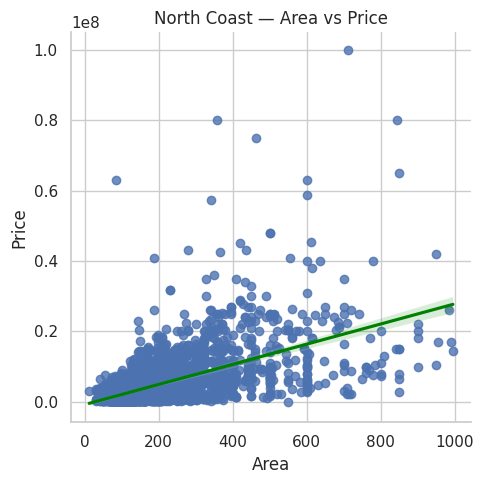

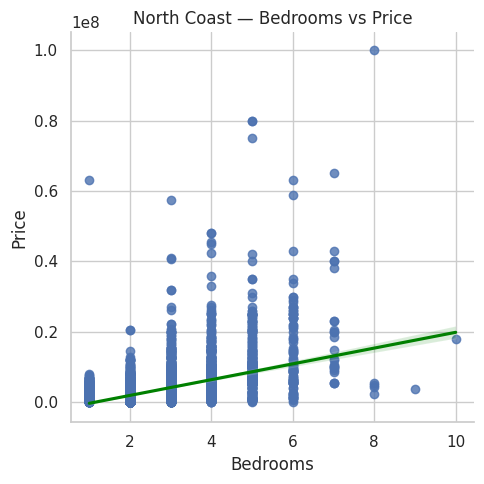

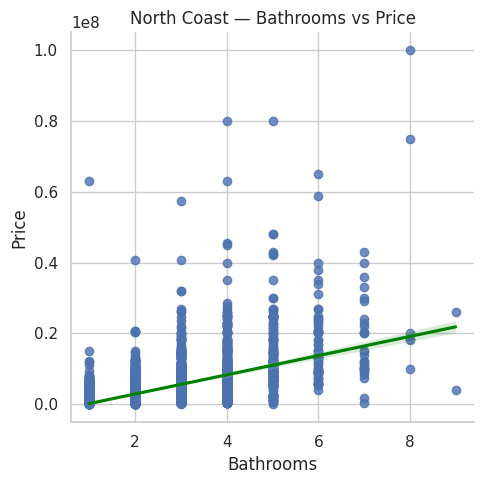


✅ Madinaty — R²: 0.6980
Coefficients: {'Area': np.float64(20248.26622043704), 'Bedrooms': np.float64(-203902.09928176797), 'Bathrooms': np.float64(1167101.4543737792)}


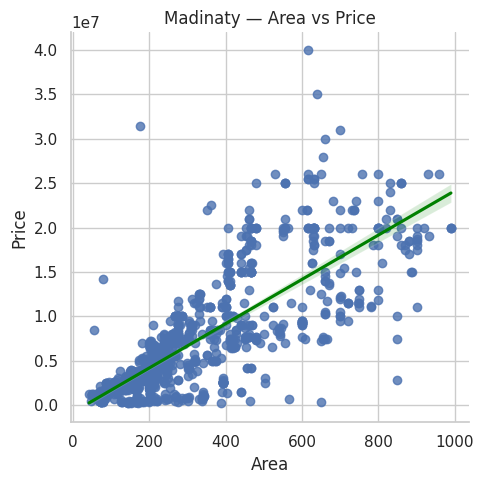

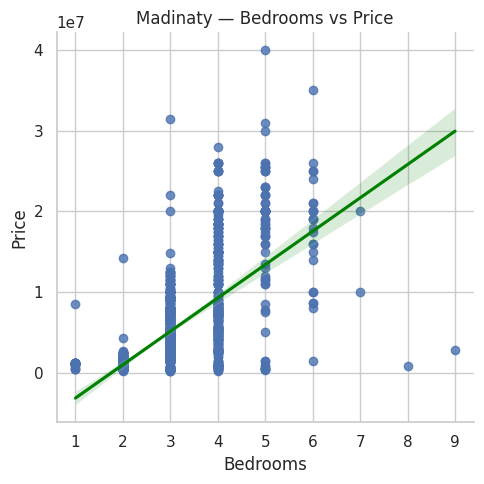

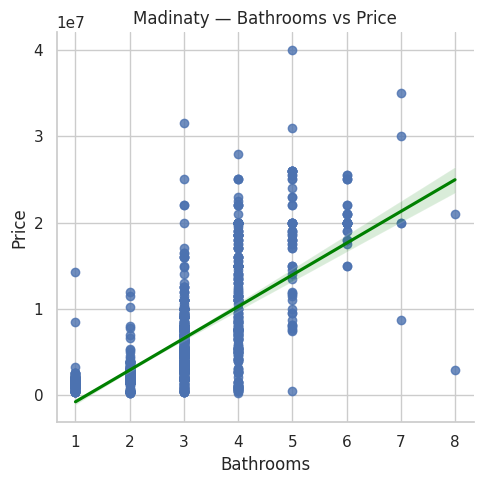


✅ New Cairo - El Tagamoa — R²: 0.5572
Coefficients: {'Area': np.float64(24028.42083086015), 'Bedrooms': np.float64(-689928.001705818), 'Bathrooms': np.float64(1333942.02629171)}


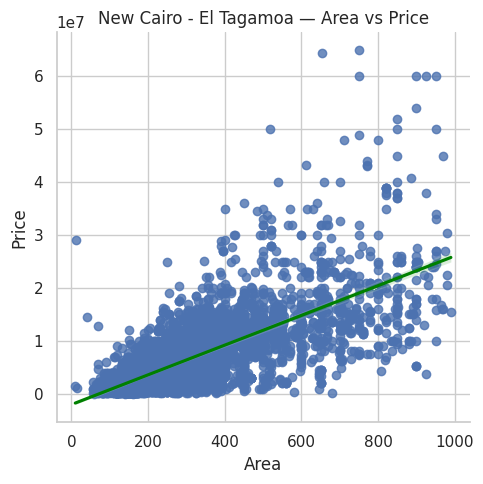

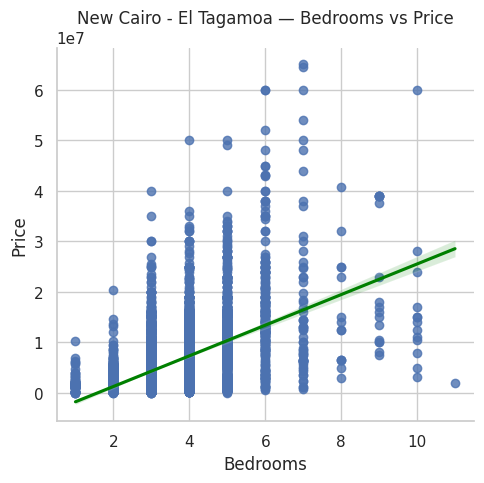

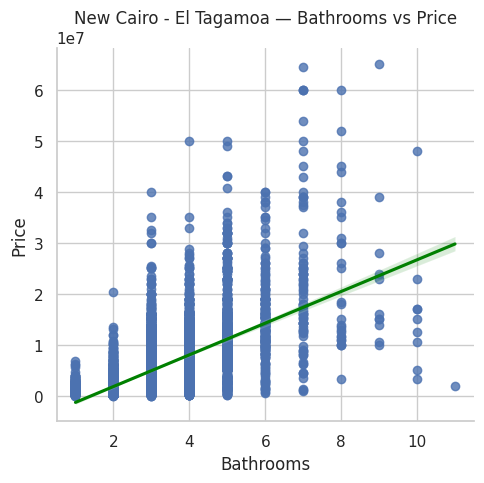


✅ Sheikh Zayed — R²: 0.3779
Coefficients: {'Area': np.float64(12937.595053771724), 'Bedrooms': np.float64(-244888.48194933223), 'Bathrooms': np.float64(1055730.9060299823)}


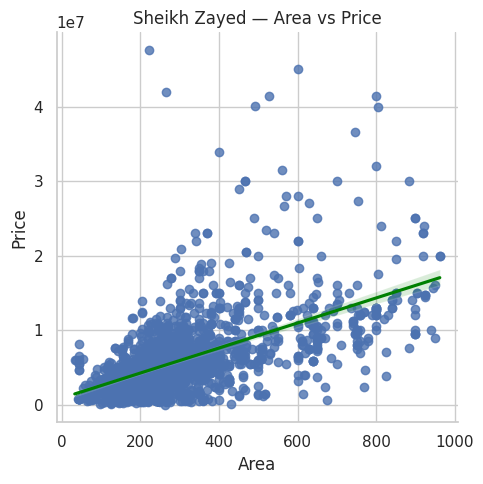

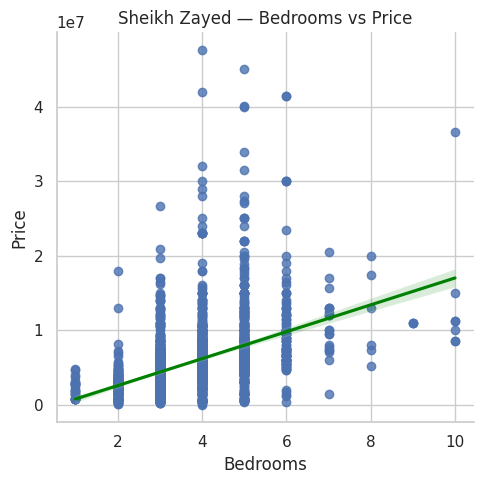

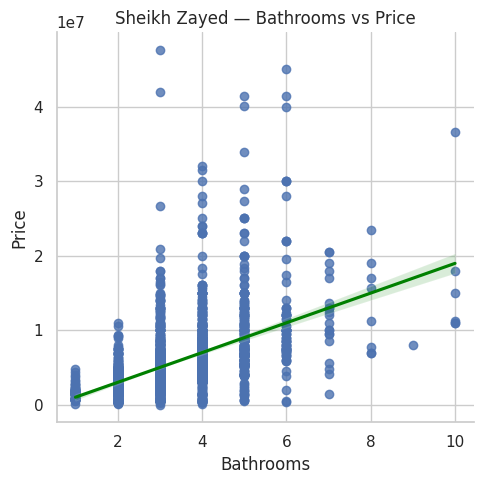

<ipython-input-89-ae79eac0181e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=r2_df, x='SubCity', y='R2', palette='viridis')


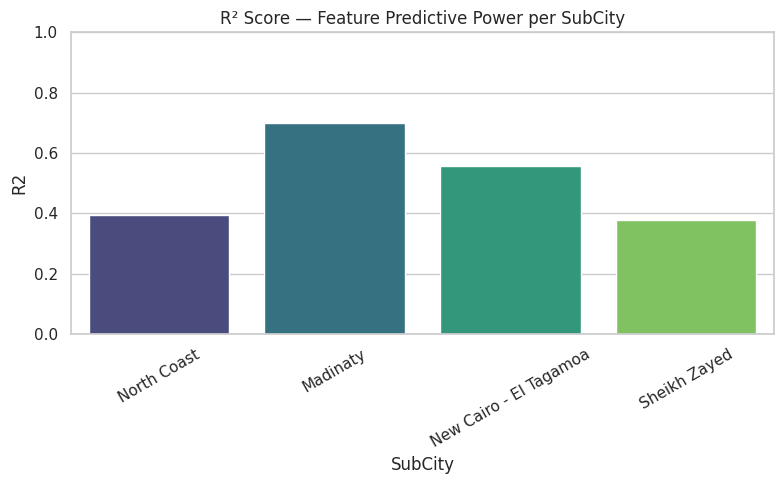

In [89]:
r2_scores = []
for sub in top_subcities:
    sub_df = df[df['City'] == sub]
    if sub_df.shape[0] < 30:
        print(f"[{sub}] ❌ Skipped (not enough data)")
        continue

    X = sub_df[['Area', 'Bedrooms', 'Bathrooms']]
    y = sub_df['Price']

    model = LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    r2_scores.append((sub, r2))

    print(f"\n✅ {sub} — R²: {r2:.4f}")
    print("Coefficients:", dict(zip(['Area', 'Bedrooms', 'Bathrooms'], model.coef_)))

    for feat in ['Area', 'Bedrooms', 'Bathrooms']:
        sns.lmplot(data=sub_df, x=feat, y='Price', line_kws={'color': 'green'})
        plt.title(f"{sub} — {feat.title()} vs Price")
        plt.tight_layout()
        plt.show()

r2_df = pd.DataFrame(r2_scores, columns=['SubCity', 'R2'])
plt.figure(figsize=(8, 5))
sns.barplot(data=r2_df, x='SubCity', y='R2', palette='viridis')
plt.title("R² Score — Feature Predictive Power per SubCity")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Bootstrap analysis for z-tests, confidence intervals, and Pearson correlations per sub-city

In [108]:
n_bootstrap = 1000

bootstrap_results = {
    "z_tests": [],
    "confidence_intervals": [],
    "pearson_correlations": []
}

for _ in range(n_bootstrap):
    bootstrap_samples = {}
    for sub_city in top_subcities:
        df_sub = df[df['Parsed_SubCity'] == sub_city]
        bootstrap_samples[sub_city] = df_sub.sample(n=len(df_sub), replace=True)

    z_test_results = {}
    for i, city1 in enumerate(top_subcities):
        for city2 in top_subcities[i+1:]:
            prices1 = bootstrap_samples[city1]['Price']
            prices2 = bootstrap_samples[city2]['Price']
            mean1, mean2 = np.mean(prices1), np.mean(prices2)
            std1, std2 = np.std(prices1, ddof=1), np.std(prices2, ddof=1)
            n1, n2 = len(prices1), len(prices2)
            pooled_se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
            z_stat = (mean1 - mean2) / pooled_se
            p_value = 2 * (1 - norm.cdf(abs(z_stat)))
            z_test_results[(city1, city2)] = {"z_stat": z_stat, "p_value": p_value}

    bootstrap_results["z_tests"].append(z_test_results)

    confidence_intervals = {}
    for sub_city in top_subcities:
        prices = bootstrap_samples[sub_city]['Price']
        mean_price = np.mean(prices)
        std_price = np.std(prices, ddof=1)
        n = len(prices)
        margin = 1.96 * (std_price / np.sqrt(n))
        confidence_intervals[sub_city] = {
            "ci_lower": mean_price - margin,
            "ci_upper": mean_price + margin
        }

    bootstrap_results["confidence_intervals"].append(confidence_intervals)

    pearson_correlations = {}
    for sub_city in top_subcities:
        corr_dict = {}
        for feature in ['Bedrooms', 'Bathrooms', 'Area']:
            corr = bootstrap_samples[sub_city][[feature, 'Price']].corr().iloc[0, 1]
            corr_dict[feature] = corr
        pearson_correlations[sub_city] = corr_dict

    bootstrap_results["pearson_correlations"].append(pearson_correlations)


mean_p_values_z = {}
std_p_values_z = {}
for pair in z_test_results.keys():
    p_vals = [bootstrap_results["z_tests"][i][pair]["p_value"] for i in range(n_bootstrap)]
    mean_p_values_z[pair] = np.mean(p_vals)
    std_p_values_z[pair] = np.std(p_vals)

mean_ci = {}
std_ci = {}
for sub_city in top_subcities:
    lowers = [bootstrap_results["confidence_intervals"][i][sub_city]["ci_lower"] for i in range(n_bootstrap)]
    uppers = [bootstrap_results["confidence_intervals"][i][sub_city]["ci_upper"] for i in range(n_bootstrap)]
    mean_ci[sub_city] = {"ci_lower": np.mean(lowers), "ci_upper": np.mean(uppers)}
    std_ci[sub_city] = {"ci_lower": np.std(lowers), "ci_upper": np.std(uppers)}

mean_pearson_corr = {}
std_pearson_corr = {}
for sub_city in top_subcities:
    corr_dict = {}
    for feature in ['Bedrooms', 'Bathrooms', 'Area']:
        corrs = [bootstrap_results["pearson_correlations"][i][sub_city][feature] for i in range(n_bootstrap)]
        corr_dict[feature] = {"mean": np.mean(corrs), "std": np.std(corrs)}
    mean_pearson_corr[sub_city] = corr_dict


print("Mean z-test p-values across bootstrap samples:")
for pair, mean_p in mean_p_values_z.items():
    print(f"{pair}: {mean_p:.4f} ± {std_p_values_z[pair]:.4f}")

print("\nMean Confidence Intervals for Mean Prices:")
for sub_city, ci in mean_ci.items():
    print(f"{sub_city}: CI = [{ci['ci_lower']:.2f}, {ci['ci_upper']:.2f}] ± "
          f"[{std_ci[sub_city]['ci_lower']:.2f}, {std_ci[sub_city]['ci_upper']:.2f}]")

print("\nMean Pearson Correlations Across Bootstrap Samples:")
for sub_city, corr_dict in mean_pearson_corr.items():
    print(f"{sub_city}:")
    for feature, stats in corr_dict.items():
        print(f"  {feature}: {stats['mean']:.4f} ± {stats['std']:.4f}")


Mean z-test p-values across bootstrap samples:
('North Coast', 'Madinaty'): 0.0000 ± 0.0000
('North Coast', 'New Cairo - El Tagamoa'): 0.0000 ± 0.0000
('North Coast', 'Sheikh Zayed'): 0.0000 ± 0.0000
('Madinaty', 'New Cairo - El Tagamoa'): 0.1409 ± 0.2095
('Madinaty', 'Sheikh Zayed'): 0.4176 ± 0.2996
('New Cairo - El Tagamoa', 'Sheikh Zayed'): 0.2248 ± 0.2596

Mean Confidence Intervals for Mean Prices:
North Coast: CI = [3602543.42, 3859400.94] ± [61404.64, 70716.20]
Madinaty: CI = [5351136.43, 5936245.39] ± [139429.19, 153054.19]
New Cairo - El Tagamoa: CI = [5830126.27, 6145945.25] ± [74374.75, 79075.16]
Sheikh Zayed: CI = [5590825.39, 5981521.25] ± [93842.60, 105476.54]

Mean Pearson Correlations Across Bootstrap Samples:
North Coast:
  Bedrooms: 0.4543 ± 0.0154
  Bathrooms: 0.5471 ± 0.0161
  Area: 0.5980 ± 0.0170
Madinaty:
  Bedrooms: 0.6392 ± 0.0215
  Bathrooms: 0.7223 ± 0.0152
  Area: 0.8249 ± 0.0124
New Cairo - El Tagamoa:
  Bedrooms: 0.5259 ± 0.0114
  Bathrooms: 0.6150 ± 0.0093

# Vzualization of Bootstrap z-tests, confidence intervals, and Pearson correlations per sub-city

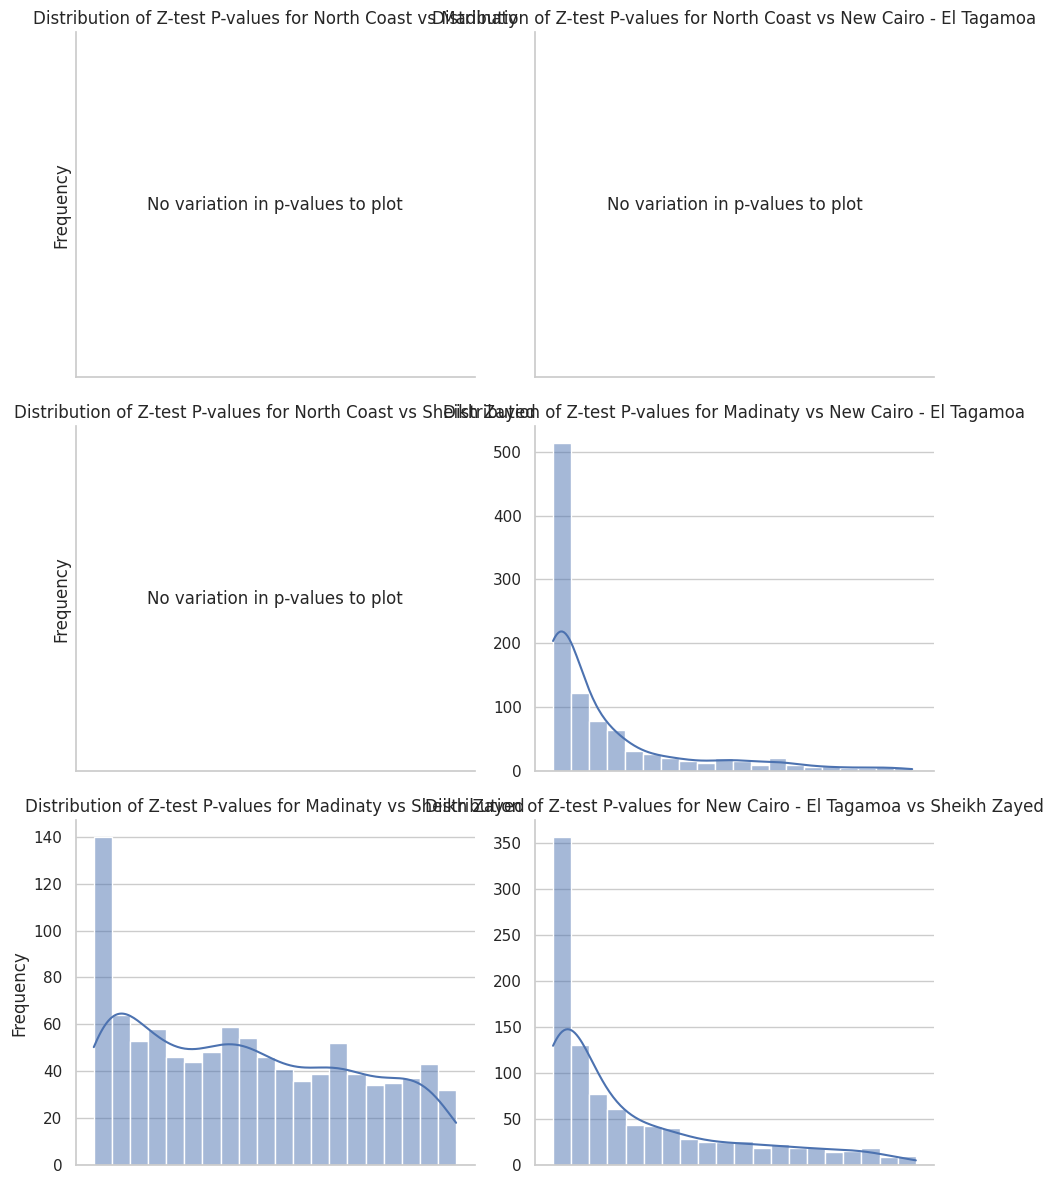

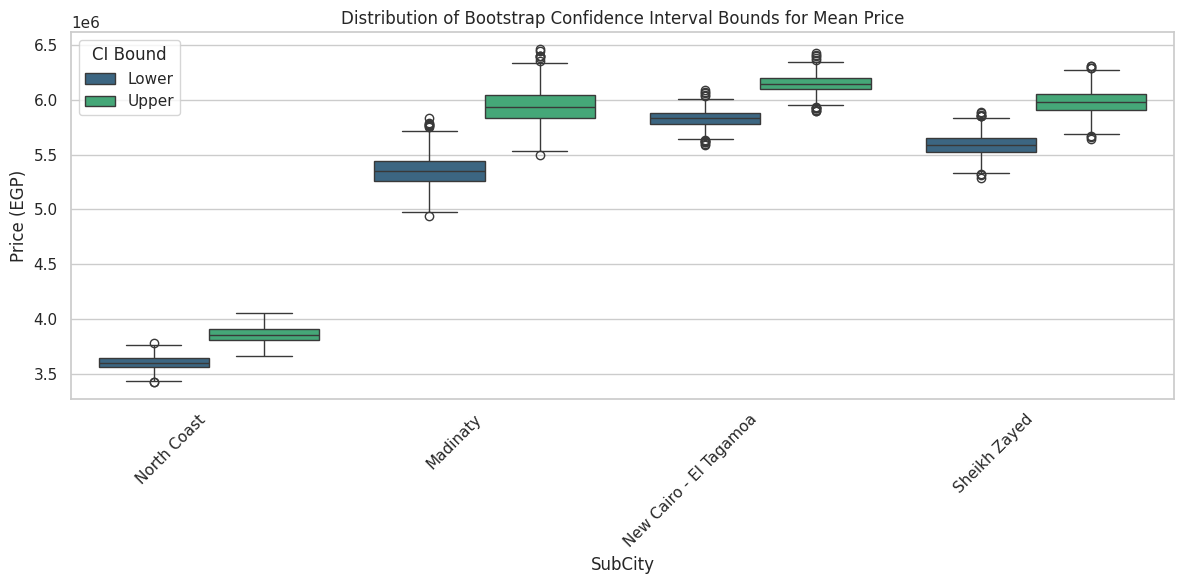

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same 

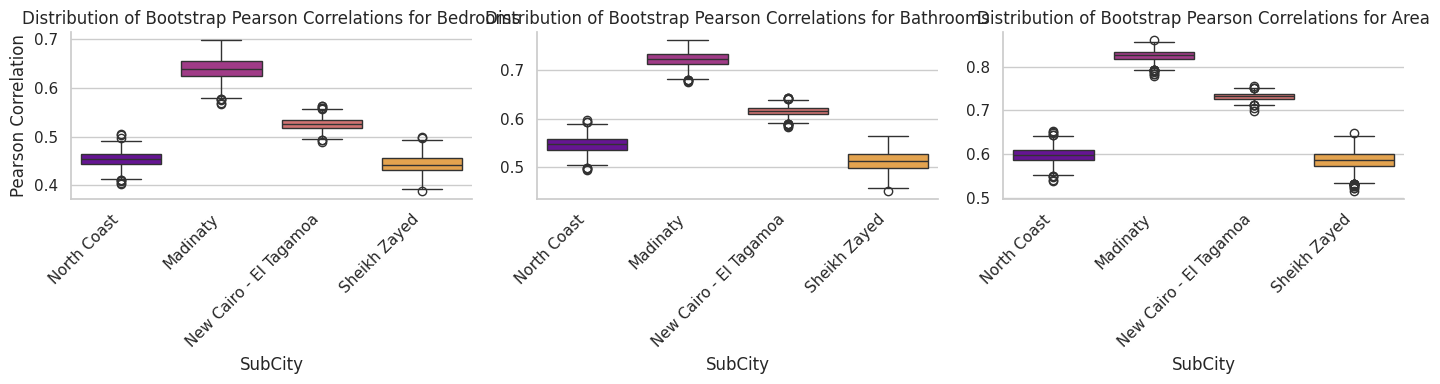

In [110]:
z_test_p_value_data = []
# Iterate through each bootstrap sample's z-test results
for z_test_res in bootstrap_results["z_tests"]:
    # Iterate through each pair of cities in the z-test results
    for pair, result in z_test_res.items():
        city1, city2 = pair
        z_test_p_value_data.append({
            'City_Pair': f"{city1} vs {city2}",
            'P_Value': result['p_value']
        })

df_z_test_p_values = pd.DataFrame(z_test_p_value_data)

if not df_z_test_p_values.empty:
    # Create a FacetGrid for each city pair
    g = sns.FacetGrid(df_z_test_p_values, col="City_Pair", col_wrap=2, height=4, aspect=1.2, sharey=False)

    def plot_hist_or_message_ztest(x, **kwargs): # Custom function for Z-test p-values
        if x.max() - x.min() > 1e-9: # Check if range is greater than a small tolerance
            sns.histplot(x=x, kde=True, binwidth=0.05, **kwargs)
        else:
            plt.text(0.5, 0.5, 'No variation in p-values to plot', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.gca().set_xticks([]) # Remove x-ticks
            plt.gca().set_yticks([]) # Remove y-ticks

    # Map the custom plotting function
    g.map(plot_hist_or_message_ztest, "P_Value")

    g.set_titles("Distribution of Z-test P-values for {col_name}")
    g.set_axis_labels("Z-test P-value", "Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No valid bootstrap z-test results to visualize p-values.")

# --- Visualize Bootstrap Confidence Intervals ---
# (Keep this part as it was in the previous corrected code)

ci_data = []
# Iterate through each bootstrap sample's confidence interval results
for ci_res in bootstrap_results["confidence_intervals"]:
    # Iterate through each sub-city's CI results
    for sub_city, ci_bounds in ci_res.items():
        ci_data.append({
            'SubCity': sub_city,
            'CI_Bound': 'Lower',
            'Price': ci_bounds['ci_lower']
        })
        ci_data.append({
            'SubCity': sub_city,
            'CI_Bound': 'Upper',
            'Price': ci_bounds['ci_upper']
        })

df_ci_bootstrap = pd.DataFrame(ci_data)

if not df_ci_bootstrap.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_ci_bootstrap, x='SubCity', y='Price', hue='CI_Bound', palette='viridis')
    plt.title("Distribution of Bootstrap Confidence Interval Bounds for Mean Price")
    plt.ylabel("Price (EGP)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="CI Bound")
    plt.tight_layout()
    plt.show()
else:
    print("No valid bootstrap confidence interval results to visualize.")

# --- Visualize Bootstrap Pearson Correlations ---
# (Keep this part as it was in the previous corrected code)

pearson_corr_data = []
# Iterate through each bootstrap sample's Pearson correlation results
for corr_res in bootstrap_results["pearson_correlations"]:
    # Iterate through each sub-city's correlation results
    for sub_city, corr_dict in corr_res.items():
        # Iterate through each feature's correlation
        for feature, corr_value in corr_dict.items():
            pearson_corr_data.append({
                'SubCity': sub_city,
                'Feature': feature,
                'Correlation': corr_value
            })

df_pearson_corr_bootstrap = pd.DataFrame(pearson_corr_data)

if not df_pearson_corr_bootstrap.empty:
    # Create a FacetGrid for each feature
    g = sns.FacetGrid(df_pearson_corr_bootstrap, col="Feature", col_wrap=3, height=4, aspect=1.2, sharey=False)

    # Map the boxplot function to show correlation distribution per sub-city
    g.map(sns.boxplot, "SubCity", "Correlation", palette='plasma')

    g.set_titles("Distribution of Bootstrap Pearson Correlations for {col_name}")
    g.set_axis_labels("SubCity", "Pearson Correlation")
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No valid bootstrap Pearson correlation results to visualize.")

# Bootstrap ANOVA Testing on Property Prices by Developer Across Subcities with Fixed Property Characteristics

In [93]:
n_bootstrap = 1000
fixed_beds = 3
fixed_baths = 2
min_area = 140
max_area = 240
top_subcities = ['North Coast', 'Madinaty', 'New Cairo - El Tagamoa', 'Sheikh Zayed']

bootstrap_anova_results = {subcity: [] for subcity in top_subcities}

for _ in range(n_bootstrap):
    for subcity in top_subcities:
        sub_df = df[
            (df['Parsed_SubCity'] == subcity) &
            (df['Bedrooms'] == fixed_beds) &
            (df['Bathrooms'] == fixed_baths) &
            (df['Area'] >= min_area) &
            (df['Area'] <= max_area)
        ].sample(frac=1, replace=True).copy()

        if sub_df.empty:
            continue

        groups = [group['Price'].values for name, group in sub_df.groupby('Compound') if len(group) >= 3]

        if len(groups) >= 2:
            try:
                f_stat, anova_p = f_oneway(*groups)
                bootstrap_anova_results[subcity].append((f_stat, anova_p))
            except ValueError:
                continue

for subcity, results in bootstrap_anova_results.items():
    if not results:
        print(f"{subcity}: No valid bootstrap samples for ANOVA")
        continue
    f_stats, p_values = zip(*results)
    mean_f = np.mean(f_stats)
    mean_p = np.mean(p_values)
    std_f = np.std(f_stats)
    std_p = np.std(p_values)

    print(f"\n{subcity} - Bootstrap ANOVA Results (n={len(results)} samples):")
    print(f"Mean F-statistic: {mean_f:.4f} ± {std_f:.4f}")
    print(f"Mean p-value: {mean_p:.4f} ± {std_p:.4f}")
    if mean_p < 0.05:
        print("Conclusion: Significant difference in mean price between developers (ANOVA).")
    else:
        print("Conclusion: No significant difference in mean price between developers (ANOVA).")



North Coast - Bootstrap ANOVA Results (n=1000 samples):
Mean F-statistic: 30.8082 ± 5.8545
Mean p-value: 0.0000 ± 0.0000
Conclusion: Significant difference in mean price between developers (ANOVA).

Madinaty - Bootstrap ANOVA Results (n=1000 samples):
Mean F-statistic: 9.5746 ± 6.6996
Mean p-value: 0.0347 ± 0.1095
Conclusion: Significant difference in mean price between developers (ANOVA).

New Cairo - El Tagamoa - Bootstrap ANOVA Results (n=1000 samples):
Mean F-statistic: 14.5759 ± 4.5417
Mean p-value: 0.0000 ± 0.0000
Conclusion: Significant difference in mean price between developers (ANOVA).

Sheikh Zayed - Bootstrap ANOVA Results (n=1000 samples):
Mean F-statistic: 24.7730 ± 8.1067
Mean p-value: 0.0000 ± 0.0000
Conclusion: Significant difference in mean price between developers (ANOVA).


# Distribution of F-statistics

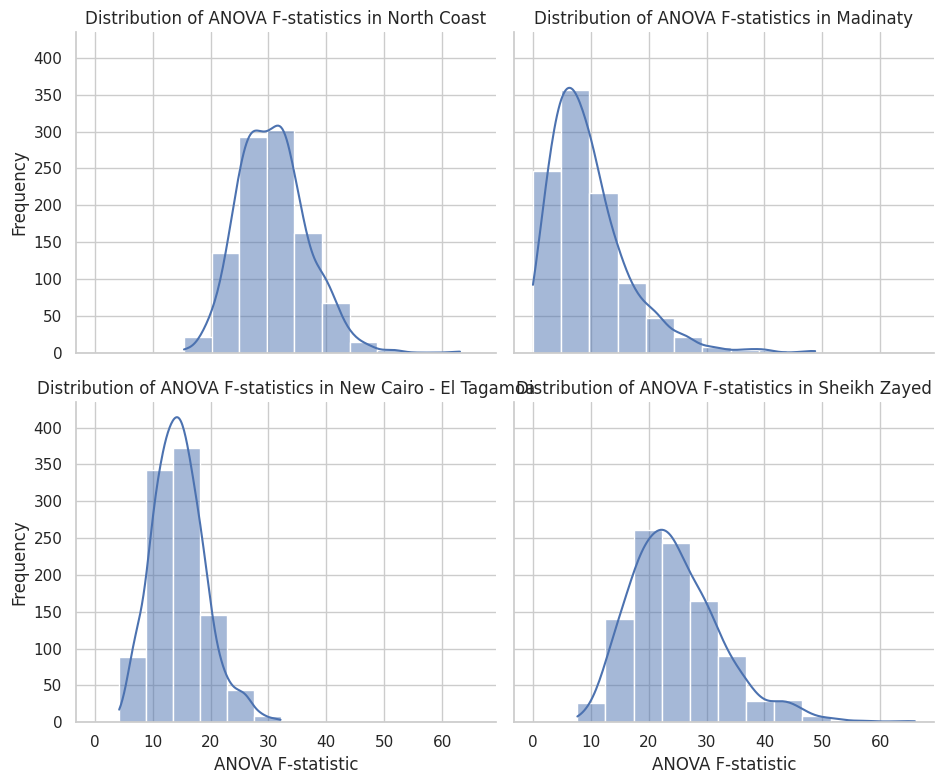

In [106]:
anova_f_stat_data = []
for subcity, results in bootstrap_anova_results.items():
     if results:
         f_stats = [f for f, p in results]
         for f in f_stats:
             anova_f_stat_data.append({'SubCity': subcity, 'F_Stat': f})

df_anova_f_stats = pd.DataFrame(anova_f_stat_data)

if not df_anova_f_stats.empty:
     g = sns.FacetGrid(df_anova_f_stats, col="SubCity", col_wrap=2, height=4, aspect=1.2)
     g.map(sns.histplot, "F_Stat", kde=True, binwidth=5) # Adjust binwidth as needed
     g.set_titles("Distribution of ANOVA F-statistics in {col_name}")
     g.set_axis_labels("ANOVA F-statistic", "Frequency")
     plt.tight_layout()
     plt.show()
else:
     print("No valid bootstrap ANOVA results to visualize F-statistics.")

# Bootstrap Linear Regression Analysis of Property Prices by Subcity with Aggregated R² Scores and Coefficients

In [94]:
n_bootstrap = 1000
bootstrap_results = {"r2_scores": [], "coefficients": []}

for _ in range(n_bootstrap):
    temp_results = {"r2_scores": {}, "coefficients": {}}
    for sub_city in top_subcities:
        sub_df = df[df['Parsed_SubCity'] == sub_city].copy()
        if len(sub_df) < 30:
            continue

        sample = sub_df.sample(n=len(sub_df), replace=True)
        X = sample[['Area', 'Bedrooms', 'Bathrooms']]
        y = sample['Price']

        try:
            model = LinearRegression()
            model.fit(X, y)
            preds = model.predict(X)
            r2 = r2_score(y, preds)
            temp_results["r2_scores"][sub_city] = r2
            temp_results["coefficients"][sub_city] = dict(zip(['Area', 'Bedrooms', 'Bathrooms'], model.coef_))
        except:
            continue

    bootstrap_results["r2_scores"].append(temp_results["r2_scores"])
    bootstrap_results["coefficients"].append(temp_results["coefficients"])

mean_r2_scores = {}
std_r2_scores = {}
mean_coefficients = {}

for sub_city in top_subcities:
    r2_vals = [res.get(sub_city, np.nan) for res in bootstrap_results["r2_scores"]]
    mean_r2_scores[sub_city] = np.nanmean(r2_vals)
    std_r2_scores[sub_city] = np.nanstd(r2_vals)

    coeffs_list = [res.get(sub_city, {}) for res in bootstrap_results["coefficients"]]
    mean_coefficients[sub_city] = {feat: np.nanmean([coeff.get(feat, np.nan) for coeff in coeffs_list]) for feat in ['Area', 'Bedrooms', 'Bathrooms']}

print("\n--- Aggregated Results Across Bootstrap Samples ---\n")
print("Mean R² Scores:")
for sub_city, mean_r2 in mean_r2_scores.items():
    print(f"{sub_city}: {mean_r2:.4f} ± {std_r2_scores[sub_city]:.4f}")

print("\nMean Coefficients:")
for sub_city, coeffs in mean_coefficients.items():
    print(f"\n{sub_city}:")
    for feat, coeff in coeffs.items():
        print(f"  {feat}: {coeff:.4f}")



--- Aggregated Results Across Bootstrap Samples ---

Mean R² Scores:
North Coast: 0.3939 ± 0.0189
Madinaty: 0.6992 ± 0.0192
New Cairo - El Tagamoa: 0.5581 ± 0.0100
Sheikh Zayed: 0.3799 ± 0.0242

Mean Coefficients:

North Coast:
  Area: 22743.5548
  Bedrooms: -871749.3215
  Bathrooms: 1712426.4501

Madinaty:
  Area: 20257.3527
  Bedrooms: -198619.8238
  Bathrooms: 1163905.0026

New Cairo - El Tagamoa:
  Area: 24064.1667
  Bedrooms: -688442.8535
  Bathrooms: 1331336.9469

Sheikh Zayed:
  Area: 12917.4429
  Bedrooms: -243273.9881
  Bathrooms: 1060988.5414


# Visualization of Bootstrap Linear Regression Analysis

<ipython-input-97-4015fc5a78fa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_r2_bootstrap, x='SubCity', y='R2', palette='viridis')


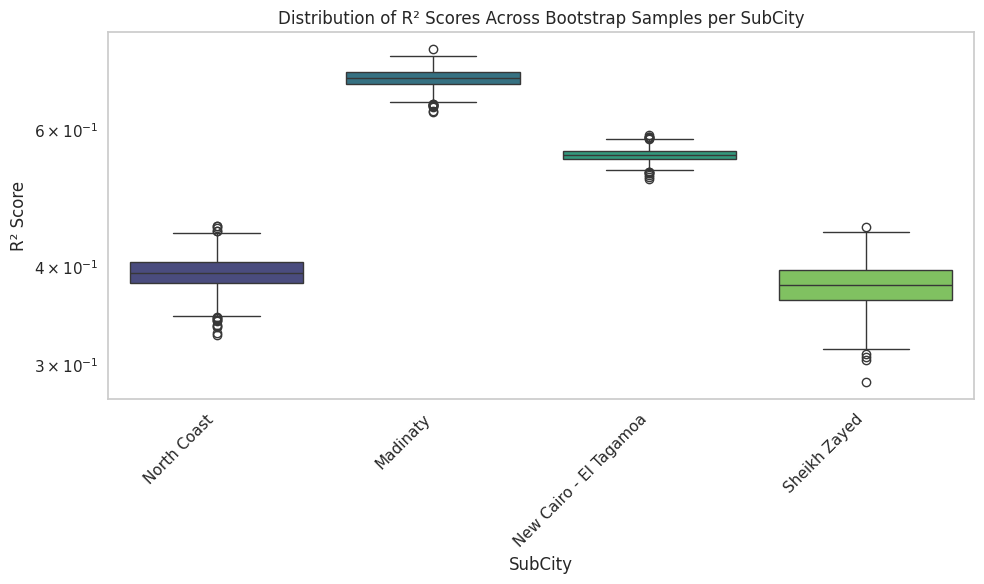

<ipython-input-97-4015fc5a78fa>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_coeffs_bootstrap[df_coeffs_bootstrap['Feature'] == feature],


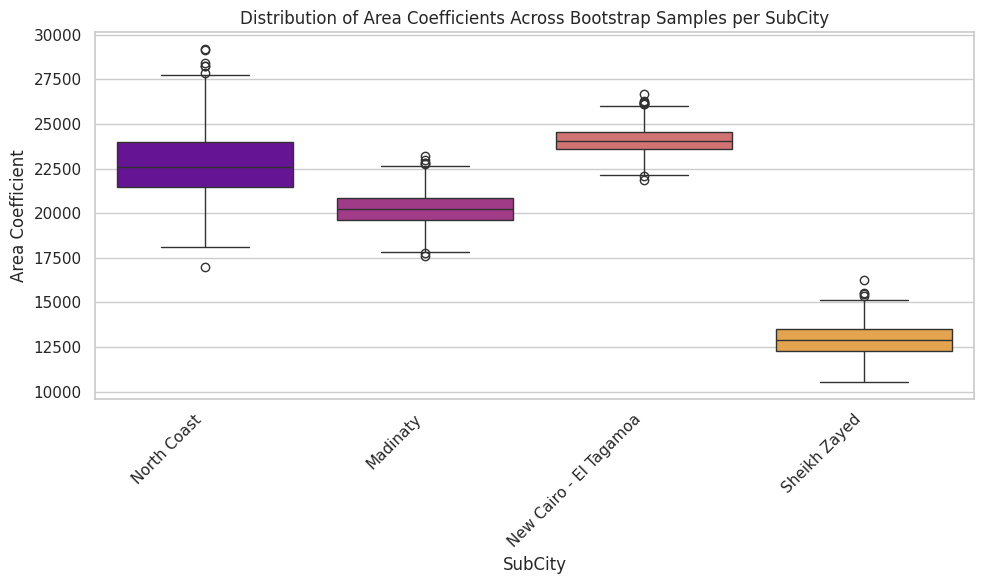

<ipython-input-97-4015fc5a78fa>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_coeffs_bootstrap[df_coeffs_bootstrap['Feature'] == feature],


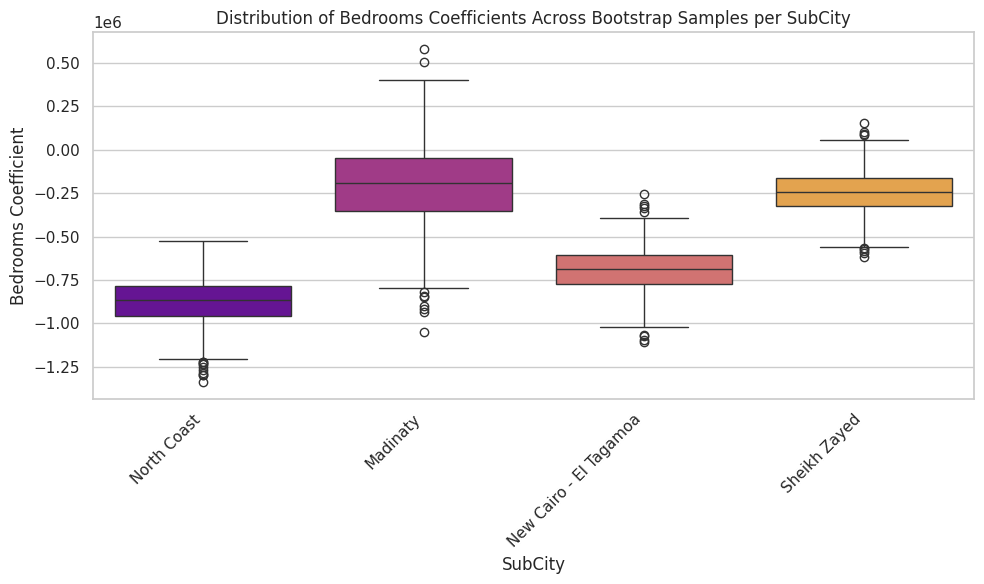

<ipython-input-97-4015fc5a78fa>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_coeffs_bootstrap[df_coeffs_bootstrap['Feature'] == feature],


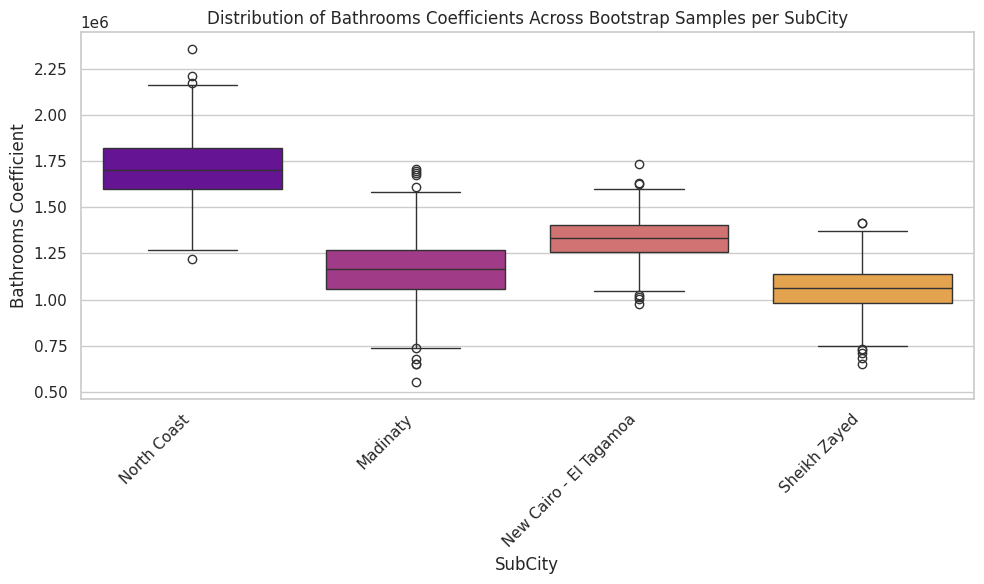

In [97]:
r2_data = []
for sub_city in top_subcities:
    r2_vals = [res.get(sub_city, np.nan) for res in bootstrap_results["r2_scores"]]
    for r2 in r2_vals:
        if not np.isnan(r2):
            r2_data.append({'SubCity': sub_city, 'R2': r2})

df_r2_bootstrap = pd.DataFrame(r2_data)

# Visualize R2 score distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_r2_bootstrap, x='SubCity', y='R2', palette='viridis')
plt.title("Distribution of R² Scores Across Bootstrap Samples per SubCity")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Prepare data for coefficient visualization
coefficient_data = []
for sub_city in top_subcities:
    coeffs_list = [res.get(sub_city, {}) for res in bootstrap_results["coefficients"]]
    for coeffs in coeffs_list:
        if coeffs: # Check if coefficients are present for this sample
            for feature, coeff_value in coeffs.items():
                coefficient_data.append({'SubCity': sub_city, 'Feature': feature, 'Coefficient': coeff_value})

df_coeffs_bootstrap = pd.DataFrame(coefficient_data)

# Visualize Coefficient distributions for each feature
for feature in ['Area', 'Bedrooms', 'Bathrooms']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_coeffs_bootstrap[df_coeffs_bootstrap['Feature'] == feature],
                x='SubCity', y='Coefficient', palette='plasma')

    plt.title(f"Distribution of {feature} Coefficients Across Bootstrap Samples per SubCity")
    plt.ylabel(f"{feature} Coefficient")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()